In [10]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [11]:
from importlib import reload
reload(data_prepro)
reload(model_train)
reload(model_fcast)

<module 'model_fcast' from 'C:\\2023_11-PTSFC\\model_fcast.py'>

### Params

In [12]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)
custom_date = '2024-01-10'
t_now = pd.Timestamp(custom_date).replace(hour=0, minute=0, second=0, microsecond=0)

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)).tz_localize('CET'))
print(subm_timestamps)

wed = 2024-01-10 00:00:00
thu = 2024-01-11 00:00:00
[Timestamp('2024-01-12 12:00:00+0100', tz='CET'), Timestamp('2024-01-12 16:00:00+0100', tz='CET'), Timestamp('2024-01-12 20:00:00+0100', tz='CET'), Timestamp('2024-01-13 12:00:00+0100', tz='CET'), Timestamp('2024-01-13 16:00:00+0100', tz='CET'), Timestamp('2024-01-13 20:00:00+0100', tz='CET')]


### Data Prep

In [13]:
# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2018-01-01'
end     = df_energy['timestamp_CET'].max()
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]

print('- '*15)
print(f"take smaller dataset ... from {start} to {end}")
print(df_energy_small.info())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# feature engineering and preparing training data

df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_fturs = df_energy_fturs['gesamt']

X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_dummy = df_energy_dummy['gesamt']

C:\2023_11-PTSFC
to_date is later than 2023-11-01, using recent data as well !


0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79123 entries, 2014-12-31 23:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79123 non-null  datetime64[ns, CET]
 1   gesamt         79123 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
- - - - - - - - - - - - - - - 
take smaller dataset ... from 2018-01-01 to 2024-01-10 18:00:00+01:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52818 entries, 2018-01-01 00:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  52818 non-null  datetime64[ns, CET]
 1   gesamt         52818 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory 

### Model Train

In [14]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models 

# # quantile regression with dummies
# all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)

# # gradient boosting with features
# all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
#     pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
#     pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# read trained models

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
train_start = X_train_dummy.index.min().strftime('%Y%m%d')
train_end = X_train_dummy.index.max().strftime('%Y%m%d')

with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'rb') as handle:
    all_models_quant_reg = pickle.load(handle)

with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'rb') as handle:
    all_models_grad_boost = pickle.load(handle)

### Iterative Ensemble Forecast from Thursday

2024-01-03 17:00:00+00:00 2024-01-10 17:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-10 18:00:00+00:00 to 2024-01-11 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


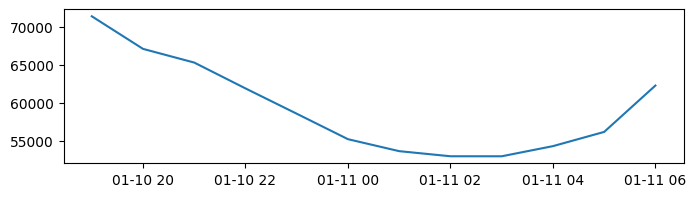

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-11 06:00:00+00:00 to 2024-01-11 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


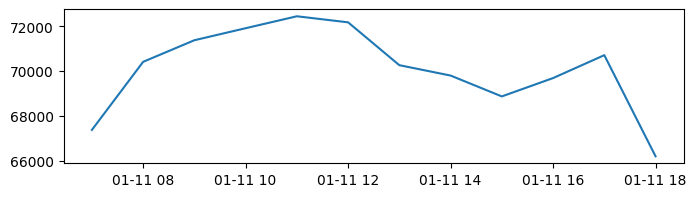

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-11 18:00:00+00:00 to 2024-01-12 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


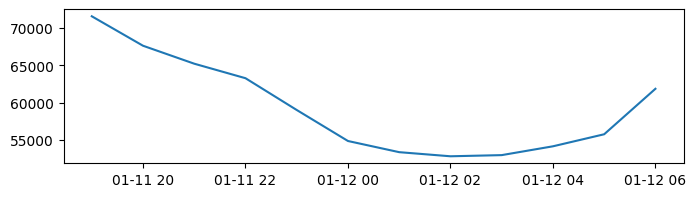

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-12 06:00:00+00:00 to 2024-01-12 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


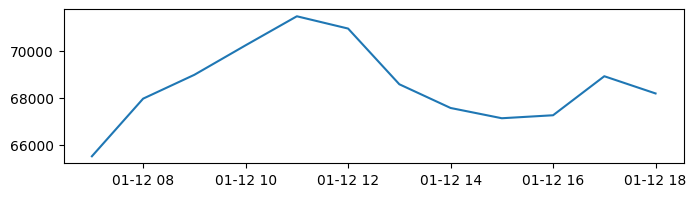

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-12 18:00:00+00:00 to 2024-01-13 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


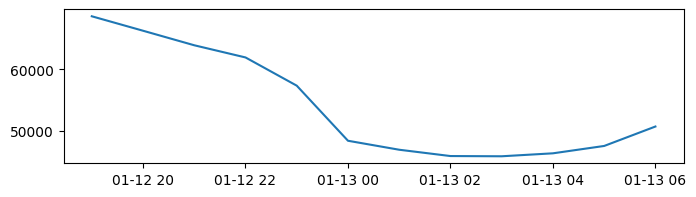

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-13 06:00:00+00:00 to 2024-01-13 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


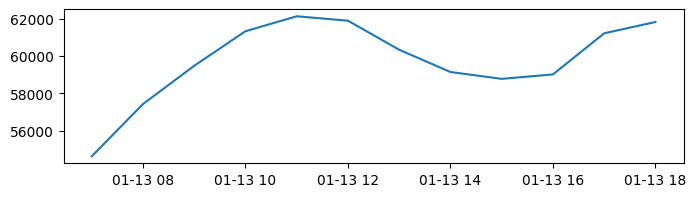

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-13 18:00:00+00:00 to 2024-01-14 05:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


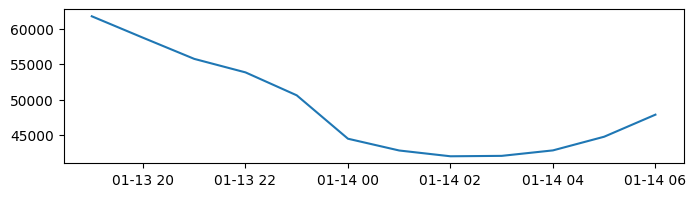

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-14 06:00:00+00:00 to 2024-01-14 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


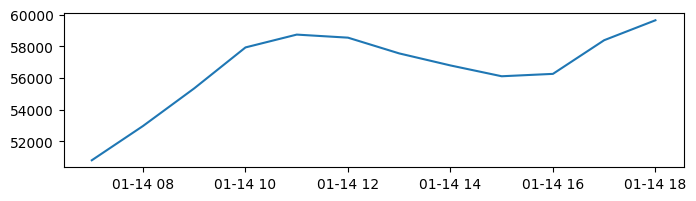

= = = = = = = = = = = = = = = 
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 18:00:00+00:00,62341.901493,69104.578668,71391.542389,71881.749487,73538.382842
2024-01-10 19:00:00+00:00,60170.997044,64881.238780,67108.984224,68434.082153,71597.979052
2024-01-10 20:00:00+00:00,57034.138927,62125.576903,65310.514719,66190.999570,68620.291471
2024-01-10 21:00:00+00:00,53560.238396,59845.389135,61916.190124,63139.119191,66151.442551
2024-01-10 22:00:00+00:00,51362.194613,56450.532481,58593.162884,59623.567797,63391.187342
...,...,...,...,...,...
2024-01-14 13:00:00+00:00,49628.573697,53657.209633,56796.781277,58967.535408,62459.624310
2024-01-14 14:00:00+00:00,48870.645299,52779.264467,56114.434176,58612.378711,61333.993208
2024-01-14 15:00:00+00:00,49387.890747,53670.950197,56265.083310,58724.998097,62254.892923
2024-01-14 16:00:00+00:00,51484.820189,56173.665259,58389.589875,61580.943410,65169.747005


In [15]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(start, end)

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()

for fcast_iter in range(8):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print('- '*15) 
    print(f"> to be forecasted")
    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    print('- '*15)    
    print(f'> start prediction ...')

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    plt.figure(figsize=(8,2))
    plt.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)
    plt.show()

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print('= '*15)
print('= '*15)
print(f"all iterative fcasts done ...")
display(df_fcast_iter_all)

#### Fix QC & Save to csv

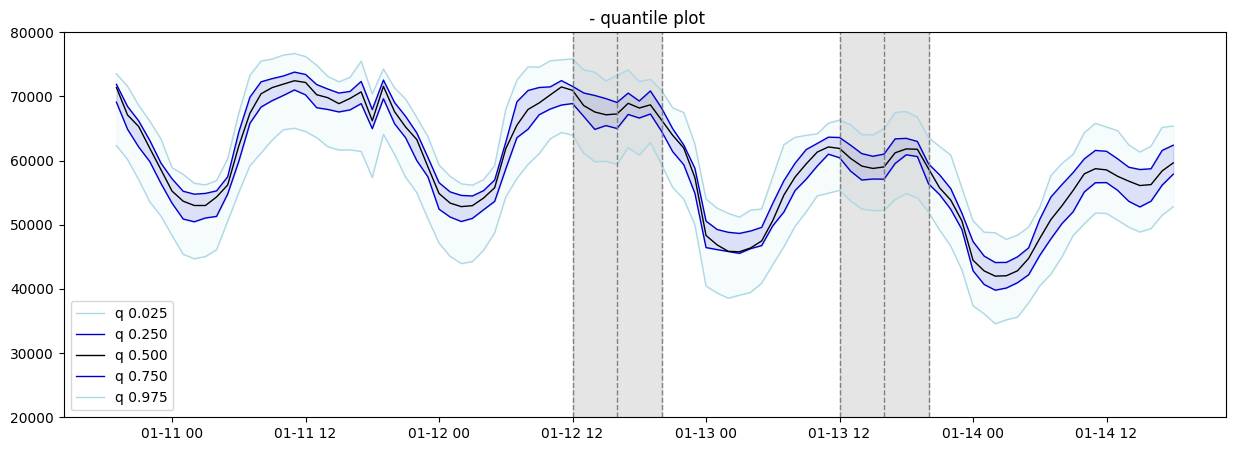

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-10,energy,36 hour,64.385521,68.658090,71.479432,72.470167,75.712150
1,2024-01-10,energy,40 hour,59.889713,65.458346,67.142078,69.661689,72.421201
2,2024-01-10,energy,44 hour,62.818724,67.265089,68.689973,70.859619,72.666128
3,2024-01-10,energy,60 hour,54.916062,60.997041,62.131891,63.654945,65.828225
4,2024-01-10,energy,64 hour,52.200372,57.131877,58.781232,60.676305,64.004191
5,2024-01-10,energy,68 hour,54.182532,60.627896,61.765410,62.983865,66.780039


In [16]:
# - - - - - - - - - - - - - 
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed['timestamp_CET'] = df_iter_fcast_all_fixed.index.tz_convert('CET')
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps)

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_iter_fcast_all_fixed['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_iter_fcast_all_fixed.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

# save entire iterative fcast to csv
df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

# save submission fcast to csv
df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
display(df_sub)

### Direct h-step Quant Reg Fcast

In [17]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

print('- '*15) 
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps 
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp['timestamp_CET'] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(df_temp, hour_method='seasonal', holiday_method='separate')
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop('timestamp_CET', axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-10 18:00:00+00:00 to 2024-01-14 17:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

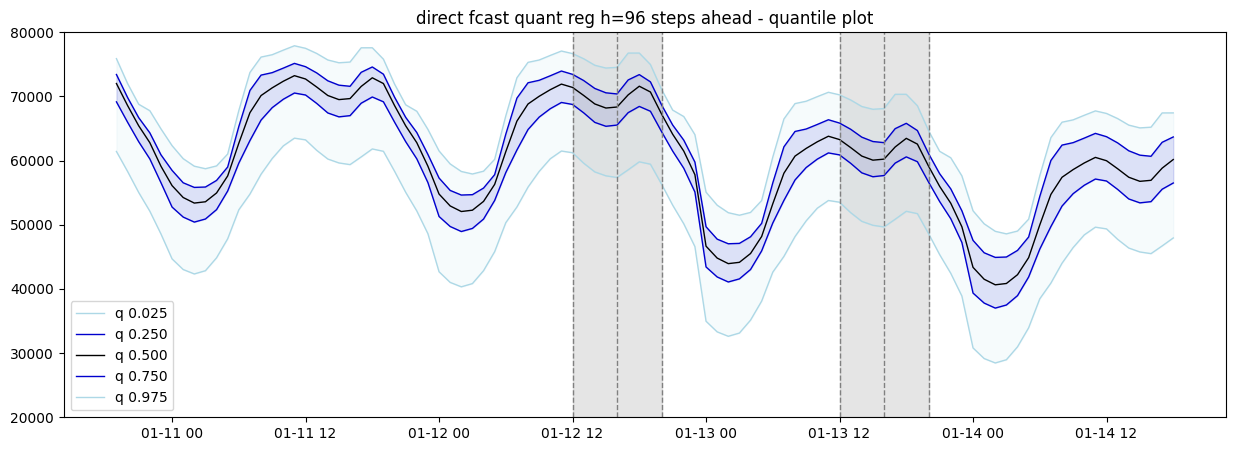

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-10,energy,36 hour,61.491685,69.062125,71.923438,73.960808,77.075250
1,2024-01-10,energy,40 hour,57.628370,65.349750,68.193062,70.567096,74.425977
2,2024-01-10,energy,44 hour,59.443337,67.692625,70.694937,72.276942,74.980227
3,2024-01-10,energy,60 hour,53.783717,61.199125,63.800125,66.369615,70.649205
4,2024-01-10,energy,64 hour,49.920402,57.486750,60.069750,62.975904,67.999932
5,2024-01-10,energy,68 hour,51.735370,59.829625,62.571625,64.685750,68.554182


In [18]:
# - - - - - - - - - - - - - 
# add CET col
df_quant_reg_direct_fcast['timestamp_CET'] = df_quant_reg_direct_fcast.index.tz_convert('CET')
# reorder cols
df_quant_reg_direct_fcast = df_quant_reg_direct_fcast[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_quant_reg_direct_fcast, subm_timestamps, title='direct fcast quant reg h=96 steps ahead')

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

display(df_sub)

### Naive Benchmark

In [19]:
print(df_energy.info())
df_energy.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79123 entries, 2014-12-31 23:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79123 non-null  datetime64[ns, CET]
 1   gesamt         79123 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-10 13:00:00+00:00,2024-01-10 14:00:00+01:00,68213.00
2024-01-10 14:00:00+00:00,2024-01-10 15:00:00+01:00,67576.00
2024-01-10 15:00:00+00:00,2024-01-10 16:00:00+01:00,67934.50
2024-01-10 16:00:00+00:00,2024-01-10 17:00:00+01:00,70504.25
2024-01-10 17:00:00+00:00,2024-01-10 18:00:00+01:00,52604.50


In [20]:
# - - - - - - - - - - - - - 
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - - 
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark['timestamp_CET'].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark['timestamp_CET'].dt.weekday # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = df_energy_benchmark['timestamp_CET'].dt.isocalendar().week

last_t = 100
methods = ['linear', 'median_unbiased', 'normal_unbiased', 'weibull']

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods),len(fcast_timestamps),5))

for i,d in enumerate(fcast_timestamps):
        
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week
    
    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2)) 
    
    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['month'].between(d.month-1, d.month+1))

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0] 

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i,:] = np.quantile(match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method)

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):

    print('- '*15)
    print(f"method = {method}")
    print('- '*15)
    
    df_benchmark = pd.DataFrame(index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles])
    df_benchmark.loc[:,:] = pred_baseline[m_idx,:,:]
    # - - - - - - - - - - - - - 
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - - 
    # add CET col
    df_benchmark['timestamp_CET'] = df_benchmark.index.tz_convert('CET')
    # reorder cols
    df_benchmark = df_benchmark[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
    # - - - - - - - - - - - - - 
    display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 77.16
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 19:00:00+01:00,2024-01-10 19:00:00+01:00,60109.18750,67264.8125,68847.250,70027.2500,71814.18750
2024-01-10 20:00:00+01:00,2024-01-10 20:00:00+01:00,56723.90625,63770.4375,65187.750,66506.2500,68116.65625
2024-01-10 21:00:00+01:00,2024-01-10 21:00:00+01:00,53696.00000,60809.3750,62474.000,63786.8125,65997.21875
2024-01-10 22:00:00+01:00,2024-01-10 22:00:00+01:00,50277.75000,56653.8125,58455.750,59833.8750,62838.68750
2024-01-10 23:00:00+01:00,2024-01-10 23:00:00+01:00,45256.67500,53175.5000,55035.250,56740.2500,58953.92500
...,...,...,...,...,...,...
2024-01-14 14:00:00+01:00,2024-01-14 14:00:00+01:00,47986.35000,51893.9375,53302.250,54949.2500,59374.81875
2024-01-14 15:00:00+01:00,2024-01-14 15:00:00+01:00,48560.70625,53052.9375,54574.625,55746.2500,59398.61875
2024-01-14 16:00:00+01:00,2024-01-14 16:00:00+01:00,51332.81875,56205.3750,58205.125,59931.9375,62524.26250
2024-01-14 17:00:00+01:00,2024-01-14 17:00:00+01:00,55378.05625,58729.8750,60676.750,62238.3750,64865.53125


- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 19:00:00+01:00,2024-01-10 19:00:00+01:00,57836.470833,67223.229167,68847.250,70041.916667,72020.337500
2024-01-10 20:00:00+01:00,2024-01-10 20:00:00+01:00,54983.031250,63732.354167,65187.750,66510.916667,68235.247917
2024-01-10 21:00:00+01:00,2024-01-10 21:00:00+01:00,52264.666667,60702.208333,62474.000,63803.562500,66048.993750
2024-01-10 22:00:00+01:00,2024-01-10 22:00:00+01:00,48721.016667,56589.562500,58455.750,59893.041667,63148.704167
2024-01-10 23:00:00+01:00,2024-01-10 23:00:00+01:00,44250.783333,52995.416667,55035.250,56743.750000,59669.116667
...,...,...,...,...,...,...
2024-01-14 14:00:00+01:00,2024-01-14 14:00:00+01:00,47123.750000,51853.541667,53302.250,54985.479167,59751.177083
2024-01-14 15:00:00+01:00,2024-01-14 15:00:00+01:00,48011.447917,53011.395833,54574.625,55766.437500,59745.843750
2024-01-14 16:00:00+01:00,2024-01-14 16:00:00+01:00,51202.510417,56200.729167,58205.125,59938.083333,62545.479167
2024-01-14 17:00:00+01:00,2024-01-14 17:00:00+01:00,54833.864583,58715.458333,60676.750,62268.562500,65026.239583


- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 19:00:00+01:00,2024-01-10 19:00:00+01:00,57978.515625,67225.828125,68847.250,70041.000000,72007.453125
2024-01-10 20:00:00+01:00,2024-01-10 20:00:00+01:00,55091.835938,63734.734375,65187.750,66510.625000,68227.835938
2024-01-10 21:00:00+01:00,2024-01-10 21:00:00+01:00,52354.125000,60708.906250,62474.000,63802.515625,66045.757812
2024-01-10 22:00:00+01:00,2024-01-10 22:00:00+01:00,48818.312500,56593.578125,58455.750,59889.343750,63129.328125
2024-01-10 23:00:00+01:00,2024-01-10 23:00:00+01:00,44313.651563,53006.671875,55035.250,56743.531250,59624.417188
...,...,...,...,...,...,...
2024-01-14 14:00:00+01:00,2024-01-14 14:00:00+01:00,47177.662500,51856.593750,53302.250,54984.296875,59727.654687
2024-01-14 15:00:00+01:00,2024-01-14 15:00:00+01:00,48045.776563,53014.171875,54574.625,55766.328125,59724.142188
2024-01-14 16:00:00+01:00,2024-01-14 16:00:00+01:00,51210.654687,56201.484375,58205.125,59937.750000,62544.153125
2024-01-14 17:00:00+01:00,2024-01-14 17:00:00+01:00,54867.876563,58716.093750,60676.750,62268.109375,65016.195312


- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 19:00:00+01:00,2024-01-10 19:00:00+01:00,56477.94375,67202.4375,68847.250,70049.2500,72433.05000
2024-01-10 20:00:00+01:00,2024-01-10 20:00:00+01:00,53921.71875,63713.3125,65187.750,66513.2500,68670.46250
2024-01-10 21:00:00+01:00,2024-01-10 21:00:00+01:00,51447.09375,60648.6250,62474.000,63811.9375,66505.10000
2024-01-10 22:00:00+01:00,2024-01-10 22:00:00+01:00,47918.57500,56557.4375,58455.750,59922.6250,63628.42500
2024-01-10 23:00:00+01:00,2024-01-10 23:00:00+01:00,43810.58750,52905.3750,55035.250,56745.5000,60100.37500
...,...,...,...,...,...,...
2024-01-14 14:00:00+01:00,2024-01-14 14:00:00+01:00,46652.54375,51829.1250,53302.250,54994.9375,59937.78125
2024-01-14 15:00:00+01:00,2024-01-14 15:00:00+01:00,47706.42500,52989.1875,54574.625,55767.3125,59945.44375
2024-01-14 16:00:00+01:00,2024-01-14 16:00:00+01:00,51081.45000,56194.6875,58205.125,59940.7500,62614.98125
2024-01-14 17:00:00+01:00,2024-01-14 17:00:00+01:00,54435.85000,58710.3750,60676.750,62272.1875,65112.86250


#### Plot Naive Benchmark

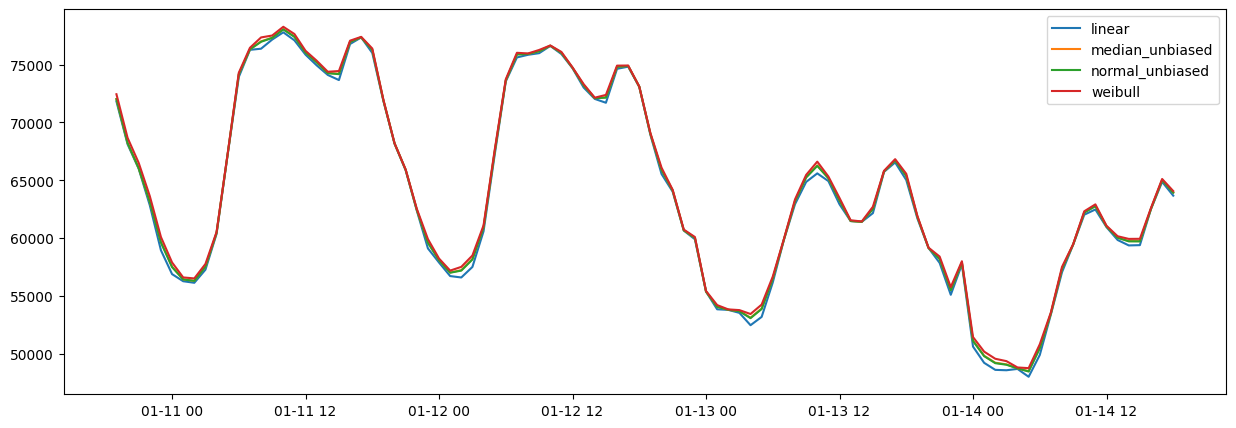

In [21]:
# compare the q 0.975 quantile of all benchmarks
plt.figure(figsize=(15,5))
for method in methods:
    plt.plot(dict_benchmark_fcast[method]['timestamp_CET'], dict_benchmark_fcast[method]['q 0.975'], label=method)
plt.legend()
plt.show()

### Get Actual Data

In [22]:
from importlib import reload
reload(data_prepro)
reload(model_train)

<module 'model_train' from 'C:\\2023_11-PTSFC\\model_train.py'>

In [23]:
""" 
now since we ran the model in retrospect on a past week 
we can compare the fcast with the actual values and compute quantile scores etc

"""

# = = = = = = = = = = = = = 
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = = 
# get data
df_energy_new = data_prepro.get_energy_data_today(to_date=t_wednesday_next.strftime('%Y%m%d'))
df_energy_new.info()
df_energy_new.tail(5)

next thu = 2024-01-17 00:00:00
C:\2023_11-PTSFC
to_date is later than 2023-11-01, using recent data as well !


4 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79290 entries, 2014-12-31 23:00:00+00:00 to 2024-01-17 16:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79290 non-null  datetime64[ns, CET]
 1   gesamt         79290 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-17 12:00:00+00:00,2024-01-17 13:00:00+01:00,71578.50
2024-01-17 13:00:00+00:00,2024-01-17 14:00:00+01:00,70569.25
2024-01-17 14:00:00+00:00,2024-01-17 15:00:00+01:00,69193.00
2024-01-17 15:00:00+00:00,2024-01-17 16:00:00+01:00,69738.50
2024-01-17 16:00:00+00:00,2024-01-17 17:00:00+01:00,70993.75


In [61]:
def eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[20_000, 80_000]):

    """ 
    imported data up to (and including) sunday of the fcast week
    first subset the required data from df_energy_new ...ie t_wednesday to t_sunday
    then plot the iterative fcast from thursday to sunday
    against the actual values in the same plot for comparison

    """
    # plot all actual values inbetween fcast timeframe
    mask = (df_energy_new['timestamp_CET'] >= df_fcast['timestamp_CET'].min()) & (df_energy_new['timestamp_CET'] <= df_fcast['timestamp_CET'].max())
    actual_df = df_energy_new.loc[mask]

    # plot actual values only for the fcast timestamps
    # actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # = = = = = = = = = = = = = 
    # plot

    plt.figure(figsize=(15, 5))
    plt.title(f'quantile fcast evaluation')

    cols = ['temp', 'lightblue', 'mediumblue', 'black', 'mediumblue', 'lightblue']
    for idx, quantile in enumerate(df_fcast.columns):
        if 'timestamp' in quantile:
            continue
        y_pred = df_fcast[quantile]
        # Plot the prediction line
        plt.plot(df_fcast['timestamp_CET'], y_pred, label=f'{quantile}', lw=1, alpha=1, color=cols[idx])

    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.025'], df_fcast['q 0.975'], color='lightblue', alpha=0.1)
    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.250'], df_fcast['q 0.750'], color='mediumblue', alpha=0.1)

    # highlight submission timeframes
    plt.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
    plt.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

    # for timestamp in submission idx, make vertical line
    for timestamp in subm_timestamps:
        plt.axvline(timestamp, color='grey', linestyle='--', lw=1)

    # plot actual values
    plt.plot(actual_df['timestamp_CET'], actual_df['gesamt'], lw=1, label='actual', color='red')

    plt.ylim(ylims)
    plt.legend()
    plt.show()

    """ 
    to calculate the error, we can only subset the actual values for the fcast timestamps
    because otherwise the actual_df will have more values than the fcast_df
    
    now that everything lines up ... we can compute the quantile scores 
    and other error metrics such as MAE, MAPE, MSE, etc
    do it for the entire iterative fcast and also for the 6 submission fcast timestamps

    """

    actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # for entire iterative fcast
    # ==========================
    print('- '*15)
    print(f"entire iterative fcast")
    print('- '*15)

    mae = mean_absolute_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAE = {mae}")
    mse = mean_squared_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MSE = {mse}")
    mape = mean_absolute_percentage_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAPE = {mape}")

    quantile_scores = []
    for q in quantiles:
        quantile_scores.append(mean_pinball_loss(actual_df['gesamt'], df_fcast[f'q {q:.3f}']))
    print(quantile_scores)

    # for submission fcast timestamps
    # ===============================
    print('- '*15)
    print(f"submission fcast timestamps")
    print('- '*15)

    mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'].isin(subm_timestamps), 'gesamt'].values, 
                              df_fcast.loc[df_fcast['timestamp_CET'].isin(subm_timestamps), 'q 0.500'].values)
    print(f"MAE q 0.5 = {mae}")

    df_error_metrics = pd.DataFrame(index=subm_timestamps)
    for timestamp in subm_timestamps:
        mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, 'q 0.500'].values)
        df_error_metrics.loc[timestamp, 'abs error q 0.5'] = mae

        for q in quantiles:
            quantile_score = mean_pinball_loss(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                               df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, f'q {q:.3f}'].values,
                                               alpha=q) / 1000 * 2
            # save in df
            df_error_metrics.loc[timestamp, f'q-score {q:.3f}'] = quantile_score

    # add last row to df_error_metrics which is the avg of the cols
    df_error_metrics.loc['avg', :] = df_error_metrics.mean(axis=0)
    
    display(df_error_metrics)

### Evaluation

#### Evaluate only Submission File

,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
timestamp_UTC,,,,,,
2024-01-12 11:00:00+00:00,2024-01-12 12:00:00+01:00,64886.625773,68714.617662,70566.814655,71805.704379,74001.419133
2024-01-12 15:00:00+00:00,2024-01-12 16:00:00+01:00,61527.319360,64794.078925,67325.175195,69182.392527,73036.033617
2024-01-12 19:00:00+00:00,2024-01-12 20:00:00+01:00,58918.015783,65641.856970,67197.108346,68824.763601,70847.354598
2024-01-13 11:00:00+00:00,2024-01-13 12:00:00+01:00,55404.914278,59657.297517,62080.286627,63618.099571,66037.722702
2024-01-13 15:00:00+00:00,2024-01-13 16:00:00+01:00,52316.316630,57414.284086,58489.970357,60848.525034,65092.144485
2024-01-13 19:00:00+00:00,2024-01-13 20:00:00+01:00,52364.608539,56348.559017,59155.364723,60002.772129,64259.275100


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-12 11:00:00+00:00,2024-01-12 12:00:00+01:00,71256.50
2024-01-12 15:00:00+00:00,2024-01-12 16:00:00+01:00,67736.50
2024-01-12 19:00:00+00:00,2024-01-12 20:00:00+01:00,63058.00
2024-01-13 11:00:00+00:00,2024-01-13 12:00:00+01:00,63372.25
2024-01-13 15:00:00+00:00,2024-01-13 16:00:00+01:00,62169.00
2024-01-13 19:00:00+00:00,2024-01-13 20:00:00+01:00,58505.75


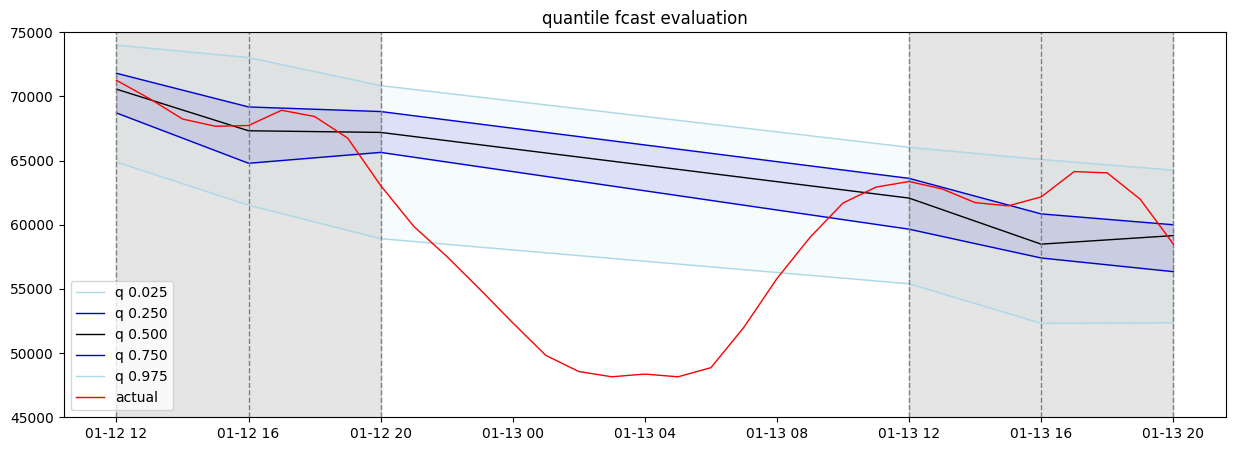

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 1810.121039235347
MSE = 5567249.9380709585
MAPE = 0.028676541178668736
[3390.016636427572, 1557.918313583176, 905.0605196176735, 902.1005977615908, 2264.662469671088]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1810.121039235347


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,689.685345,0.318494,1.270941,0.689685,0.274602,0.137246
2024-01-12 16:00:00+01:00,411.324805,0.310459,1.471211,0.411325,0.722946,0.264977
2024-01-12 20:00:00+01:00,4139.108346,0.206999,3.875785,4.139108,2.883382,0.389468
2024-01-13 12:00:00+01:00,1291.963373,0.398367,1.857476,1.291963,0.122925,0.133274
2024-01-13 16:00:00+01:00,3679.029643,0.492634,2.377358,3.679030,1.980712,0.146157
2024-01-13 20:00:00+01:00,649.614723,0.307057,1.078595,0.649615,0.748511,0.287676
avg,1810.121039,0.339002,1.988561,1.810121,1.122180,0.226466


In [62]:
# read in csv file

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

# get csv filename from path that includes Thormund
fnames = [f for f in os.listdir(path) if 'Tormund' in f]
if len(fnames) > 0:
    fname = fnames[0]
else:
    print("no file found")

df_fcast = pd.read_csv(f"{path}/{fname}")
df_fcast = df_fcast[df_fcast.target == 'energy']
df_fcast['timestamp_CET'] = subm_timestamps
# make index = timestamp_CET turned to UTC
df_fcast.index = pd.to_datetime(df_fcast['timestamp_CET']).dt.tz_convert('UTC').rename('timestamp_UTC')
df_fcast = df_fcast[['timestamp_CET', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']]
df_fcast.columns = ['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']
df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] = df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] * 1000

display(df_fcast)
display(df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])])

eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[45_000, 75_000])

#### Evaluate Entire Fcast

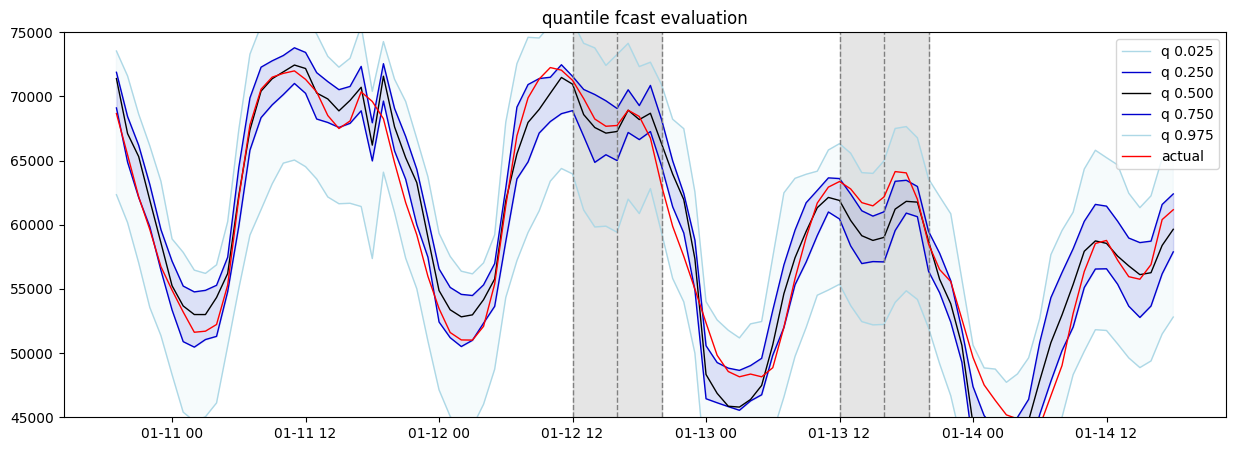

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 1761.4371418693884
MSE = 4756950.811259508
MAPE = 0.0313409315189332
[3659.214418809941, 1104.1900163184011, 880.7185709346942, 1191.8974011287503, 2574.4667743667474]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1482.5596361417727


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,299.905090,182.339875,590.655524,149.952545,77.906842,114.640962
2024-01-12 16:00:00+01:00,467.529911,207.990494,682.567276,233.764955,331.980506,138.311538
2024-01-12 20:00:00+01:00,3268.445137,91.685081,1142.376648,1634.222568,1286.156595,196.647974
2024-01-13 12:00:00+01:00,1477.567856,200.128851,730.478619,738.783928,57.451783,73.749186
2024-01-13 16:00:00+01:00,3151.201889,248.309094,1265.464638,1575.600945,867.126058,70.373755
2024-01-13 20:00:00+01:00,230.707934,163.554963,530.708200,115.353967,246.201957,126.865864
avg,1482.559636,182.334726,823.708484,741.279818,477.803957,120.098213


In [33]:
eval_fcast(df_iter_fcast_all_fixed, df_energy_new, subm_timestamps, quantiles, ylims=[45_000, 75_000])

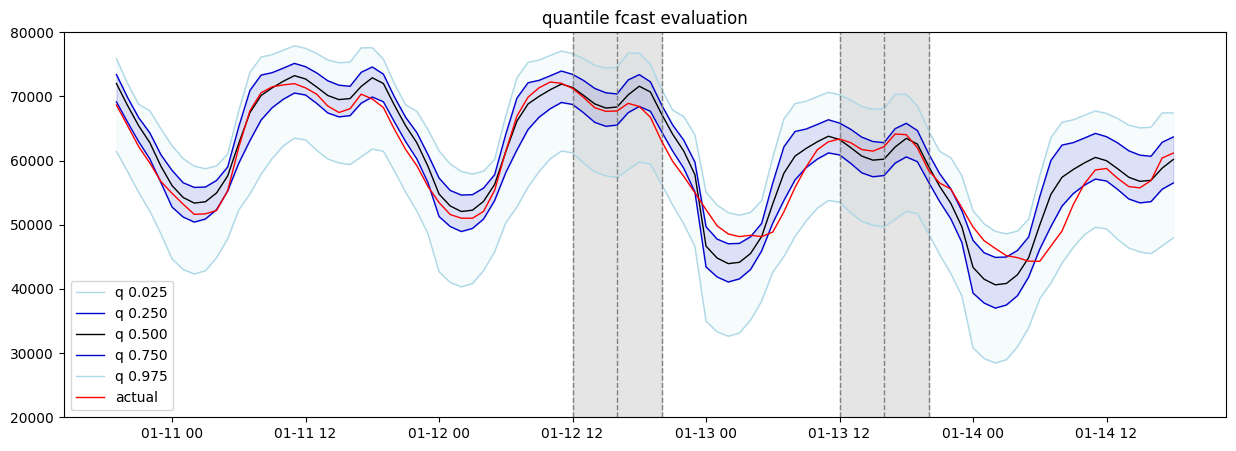

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2300.3515625
MSE = 8736753.388020834
MAPE = 0.04167817326598227
[5098.008774909422, 1359.181640625, 1150.17578125, 1900.8616786858972, 3559.9147727272743]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1273.5104166666667


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,147.437500,250.784511,625.6250,73.718750,547.057692,135.488636
2024-01-12 16:00:00+01:00,615.937500,259.183696,549.3750,307.968750,663.341346,169.988636
2024-01-12 20:00:00+01:00,4208.625000,168.072826,1099.1250,2104.312500,1409.812500,201.198295
2024-01-13 12:00:00+01:00,91.625000,246.377446,620.3125,45.812500,620.322115,171.943750
2024-01-13 16:00:00+01:00,1939.875000,312.695380,1123.2500,969.937500,157.418269,148.525000
2024-01-13 20:00:00+01:00,637.562500,246.965761,461.3125,318.781250,650.076923,154.353409
avg,1273.510417,247.346603,746.5000,636.755208,674.671474,163.582955


In [27]:
eval_fcast(df_quant_reg_direct_fcast, df_energy_new, subm_timestamps, quantiles)

#### Evaluation of Benchmark

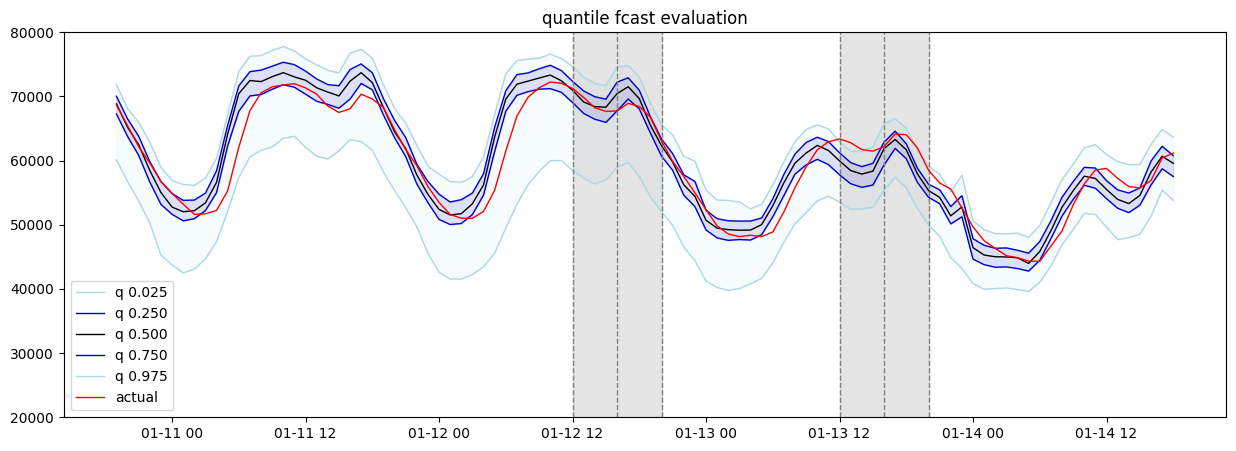

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2059.7109375
MSE = 7704627.143229167
MAPE = 0.0352425610292599
[4255.110872395832, 1141.4378255208333, 1029.85546875, 1318.9404296875, 2284.2618815104165]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1771.1875


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,295.2500,320.370000,550.437500,147.62500,274.250000,85.480625
2024-01-12 16:00:00+01:00,2697.7500,219.658750,6.937500,1348.87500,1120.125000,172.261250
2024-01-12 20:00:00+01:00,734.2500,275.328125,594.250000,367.12500,76.250000,62.144375
2024-01-13 12:00:00+01:00,3414.8750,245.871719,1398.093750,1707.43750,1609.453125,437.482500
2024-01-13 16:00:00+01:00,311.0000,169.332656,713.281250,155.50000,174.500000,88.909688
2024-01-13 20:00:00+01:00,3174.0000,213.622031,1054.515625,1587.00000,1641.890625,16.245781
avg,1771.1875,240.697214,719.585938,885.59375,816.078125,143.754036


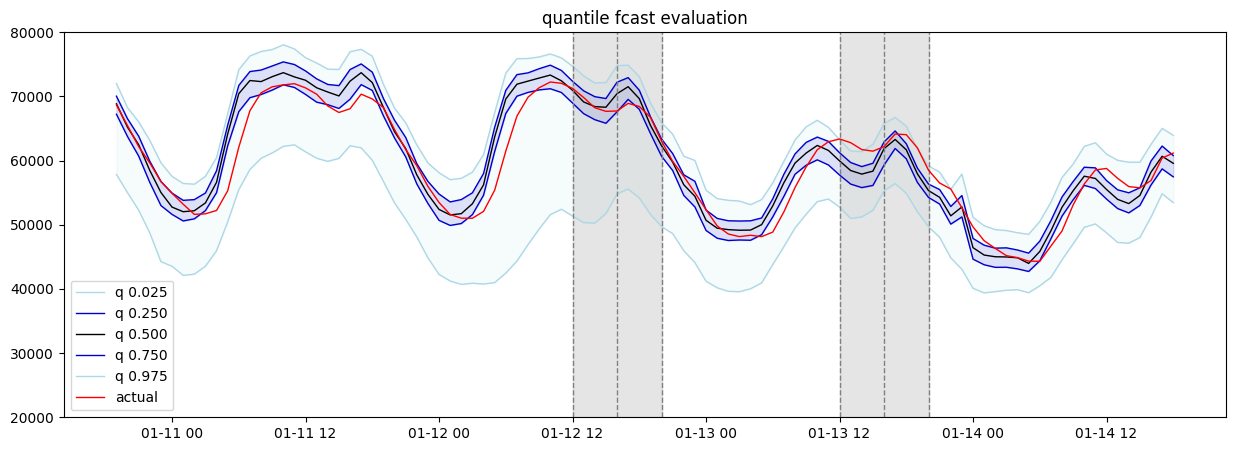

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2059.7109375
MSE = 7704627.143229167
MAPE = 0.0352425610292599
[5132.148893229166, 1150.9433593749998, 1029.85546875, 1326.7183159722224, 2398.517523871527]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1771.1875


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,295.2500,497.552917,571.104167,147.62500,277.750000,86.466250
2024-01-12 16:00:00+01:00,2697.7500,322.512083,34.062500,1348.87500,1120.562500,176.726250
2024-01-12 20:00:00+01:00,734.2500,333.535417,594.250000,367.12500,77.958333,71.450417
2024-01-13 12:00:00+01:00,3414.8750,265.002344,1403.635417,1707.43750,1604.437500,95.387500
2024-01-13 16:00:00+01:00,311.0000,171.561198,718.390625,155.50000,183.604167,90.152604
2024-01-13 20:00:00+01:00,3174.0000,220.141406,1061.817708,1587.00000,1624.250000,16.368490
avg,1771.1875,301.717561,730.543403,885.59375,814.760417,89.425252


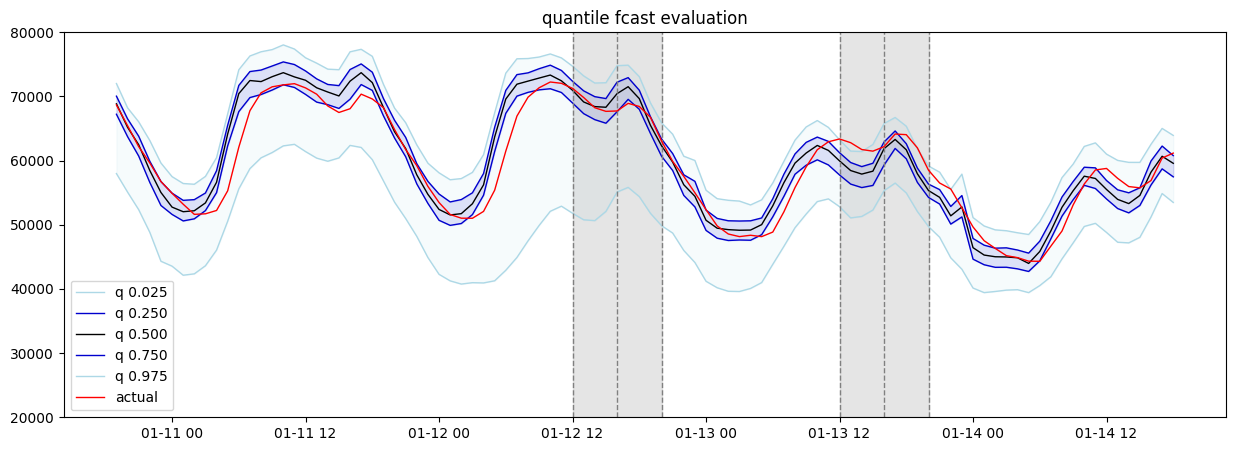

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2059.7109375
MSE = 7704627.143229167
MAPE = 0.0352425610292599
[5077.334016927083, 1150.3055826822917, 1029.85546875, 1326.2730305989583, 2391.376546223959]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1771.1875


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,295.2500,486.478984,569.812500,147.62500,277.531250,86.404648
2024-01-12 16:00:00+01:00,2697.7500,316.083750,31.789062,1348.87500,1120.535156,176.447188
2024-01-12 20:00:00+01:00,734.2500,329.897461,594.250000,367.12500,77.851562,70.868789
2024-01-13 12:00:00+01:00,3414.8750,263.806680,1402.820312,1707.43750,1604.625000,116.768437
2024-01-13 16:00:00+01:00,311.0000,171.421914,718.042969,155.50000,182.140625,90.074922
2024-01-13 20:00:00+01:00,3174.0000,219.733945,1061.019531,1587.00000,1627.265625,16.360820
avg,1771.1875,297.903789,729.622396,885.59375,814.991536,92.820801


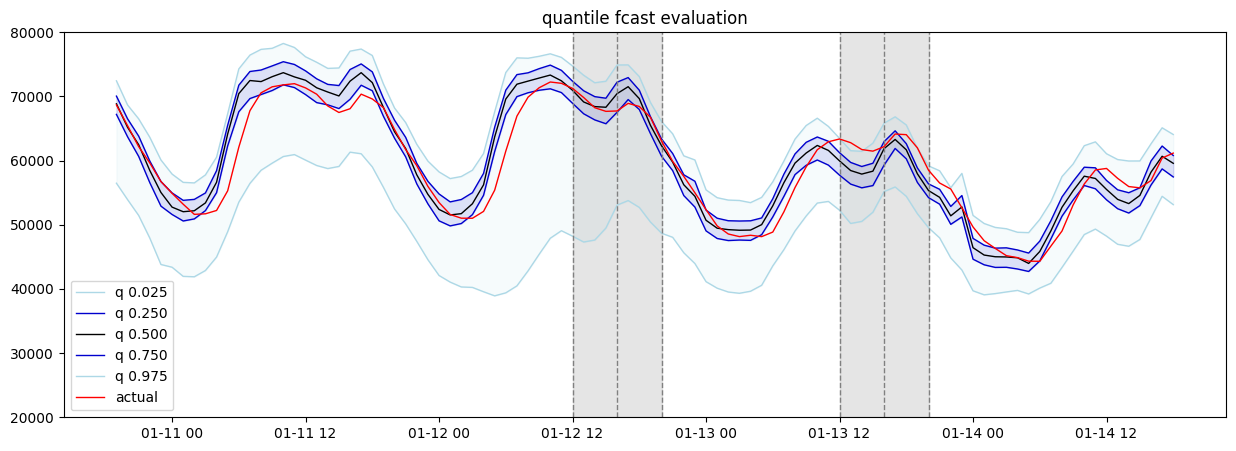

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2059.7109375
MSE = 7704627.143229167
MAPE = 0.0352425610292599
[5618.177343750001, 1156.0455729166667, 1029.85546875, 1330.2805989583333, 2473.3233398437455]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1771.1875


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-12 12:00:00+01:00,295.2500,575.758438,581.437500,147.62500,279.500000,87.253125
2024-01-12 16:00:00+01:00,2697.7500,366.987188,52.250000,1348.87500,1120.781250,179.137188
2024-01-12 20:00:00+01:00,734.2500,359.273438,594.250000,367.12500,78.812500,75.831250
2024-01-13 12:00:00+01:00,3414.8750,277.580000,1410.156250,1707.43750,1602.937500,2.415156
2024-01-13 16:00:00+01:00,311.0000,175.000312,721.171875,155.50000,195.312500,91.267500
2024-01-13 20:00:00+01:00,3174.0000,224.125469,1068.203125,1587.00000,1600.125000,16.917031
avg,1771.1875,329.787474,737.911458,885.59375,812.911458,75.470208


In [28]:
# iterate over dict dict_benchmark_fcast
for method, df_benchmark in dict_benchmark_fcast.items():
    eval_fcast(df_benchmark, df_energy_new, subm_timestamps, quantiles)